# Text Mining para detectar textos sobre desastres en Tweets

### Limpieza y preprocesamiento de texto

In [13]:
import re
import unicodedata
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Patrones reutilizables

In [3]:
URL_RE = re.compile(r'https?://\S+|[www.\S+](http://www.\S+)', flags=re.IGNORECASE)
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#(\w+)')
HTML_TAG_RE    = re.compile(r'<.*?>')
EMOTICON_RE    = re.compile(
	r'(?:\:\)|:-\)|:\$|:-\(|:D|;\-\)|;\-\(|:-/|:\/|:\'\(|:P|:-P|;P|;-P|:o|:-o|:O|:-O)'
)
EMOJI_RE = re.compile('\[\U00010000-\U0010FFFF]', flags=re.UNICODE)
MULTISPACE_RE = re.compile(r'\s+')


<>:8: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
C:\Users\n8nug\AppData\Local\Temp\ipykernel_24168\2624057981.py:8: SyntaxWarning: invalid escape sequence '\['
  EMOJI_RE = re.compile('\[\U00010000-\U0010FFFF]', flags=re.UNICODE)


#### Stopwords de scikit-learn y preservación de negaciones

In [ ]:
_stopwords = set(ENGLISH_STOP_WORDS)
_neg_keep = {"not", "no", "nor", "never"}
_stopwords = _stopwords.difference(_neg_keep)

def _normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)

def _expand_contractions(text: str) -> str:
    text = re.sub(r"\bwon't\b", "will not", text, flags=re.IGNORECASE)
    text = re.sub(r"\bcan't\b", "can not", text, flags=re.IGNORECASE)
    text = re.sub(r"n['’]t\b", " not", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]re\b", " are", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]s\b", " is", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]d\b", " would", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]ll\b", " will", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]ve\b", " have", text, flags=re.IGNORECASE)
    text = re.sub(r"['’]m\b", " am", text, flags=re.IGNORECASE)
    return text

def _collapse_elongations(text: str) -> str:
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

In [ ]:
def clean_text(
    text,
    lowercase: bool = True,
    remove_urls: bool = True,
    remove_mentions: bool = True,
    strip_hashtag_sign: bool = True,
    remove_emoticons: bool = True,
    remove_emojis: bool = True,
    remove_punctuation: bool = True,
    remove_numbers: bool = True,
    keep_911: bool = True,
    remove_stopwords: bool = True,
    keep_negations: bool = True,
    collapse_repeated_chars: bool = True,
    ):
    
    """
    Retorna un string limpio listo para vectorizar.

    Parámetros clave:
    - remove_numbers: elimina números (útil para ruido)
    - keep_911: si True, preserva el token '911' aunque remove_numbers=True
    - remove_stopwords: quita artículos/preposiciones/conjunciones
    - keep_negations: conserva 'no', 'not', 'never', 'nor'
    """

    if text is None:
        return ""
    text = _normalize_unicode(str(text))
    if lowercase:
        text = text.lower()
    text = _expand_contractions(text)

    if remove_urls:
        text = URL_RE.sub(" ", text)
    if remove_mentions:
        text = MENTION_RE.sub(" ", text)
    if strip_hashtag_sign:
        text = HASHTAG_RE.sub(r"\1", text)

    text = HTML_TAG_RE.sub(" ", text)
    if remove_emoticons:
        text = EMOTICON_RE.sub(" ", text)
    if remove_emojis:
        text = EMOJI_RE.sub(" ", text)

    if remove_numbers and keep_911:
        text = re.sub(r"\b911\b", "__PRESERVE_911__", text)

    if remove_punctuation:
        text = re.sub(r"[^a-zA-Z\s]", " ", text)

    if remove_numbers and keep_911:
        text = text.replace("__PRESERVE_911__", "911")

    if collapse_repeated_chars:
        text = _collapse_elongations(text)

    tokens = text.split()
    if remove_stopwords:
        sw = set(_stopwords)
        if keep_negations:
            sw = sw.difference(_neg_keep)
        tokens = [t for t in tokens if t not in sw]

    text = " ".join(tokens)
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text

#### Uso sobre el dataframe `df`

In [7]:
df = pd.read_csv("train.csv")

df["clean_text"] = df["text"].apply(
    lambda t: clean_text(
    t,
    remove_numbers=True,
    keep_911=True,
    remove_stopwords=True,
    keep_negations=True,
    )
)

# (opcional) Tokens como lista:
df["tokens"] = df["clean_text"].str.split()
df[["id", "text", "clean_text", "target"]].head()

,id,text,clean_text,target
0,1,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake allah forgive,1
1,4,Forest fire near La Ronge Sask. Canada,forest near la ronge sask canada,1
2,5,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,1
3,6,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders cal...,1
4,7,Just got sent this photo from Ruby #Alaska as ...,just got sent photo ruby alaska smoke wildfire...,1


#### Frecuencia de palabras (desastre vs. no) y n-gramas

In [ ]:
def get_top_ngrams(texts, ngram_range=(1,1), top_n=25, min_df=1):
    """
    Retorna un DataFrame con las frecuencias de n-gramas más comunes en 'texts'.
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vectorizer.fit_transform(texts)
    vocab = np.array(vectorizer.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1]
    top_idx = order[:top_n]
    
    return pd.DataFrame({
        "ngram": vocab[top_idx],
        "freq": freqs[top_idx]
    })

In [ ]:
def plot_top_bars(df_freq, title, top_n=15):
    """
    Grafica barras para los top_n n-gramas de un DataFrame con columnas ['ngram','freq'].
    Reglas: matplotlib, una sola figura, sin estilo ni colores específicos.
    """
    
    top = df_freq.head(top_n).iloc[::-1]
    plt.figure(figsize=(8, 5))
    plt.barh(top['ngram'], top['freq'])
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('Término')
    plt.tight_layout()
    plt.show()

In [ ]:
def chi2_informative_terms(texts, y, ngram_range=(1,1), top_k=25, min_df=2):
    """
    Devuelve dos DataFrames con los términos más asociados a cada clase según chi-cuadrado.
    - top_disaster: términos fuertemente asociados a target=1
    - top_nondisaster: términos fuertemente asociados a target=0
    """
    vectorizer = CountVectorizer(ngram_range=ngram_range, min_df=min_df)
    X = vectorizer.fit_transform(texts)
    feature_names = np.array(vectorizer.get_feature_names_out())
    chi2_vals, p = chi2(X, y)

    # Orden global
    order = np.argsort(chi2_vals)[::-1]

    # Para separarlos por clase, calculamos la media de X en cada clase
    X1_mean = X[y == 1].mean(axis=0).A1 + 1e-9
    X0_mean = X[y == 0].mean(axis=0).A1 + 1e-9
    log_ratio = np.log(X1_mean / X0_mean)

    # Términos pro-clase 1: alto chi2 y log_ratio positivo
    mask1 = log_ratio > 0
    order1 = np.argsort(chi2_vals * mask1)[::-1]
    top1 = [i for i in order1 if mask1[i]][:top_k]

    # Términos pro-clase 0: alto chi2 y log_ratio negativo
    mask0 = log_ratio < 0
    order0 = np.argsort(chi2_vals * mask0)[::-1]
    top0 = [i for i in order0 if mask0[i]][:top_k]
    top_disaster = pd.DataFrame({"term": feature_names[top1], "chi2": chi2_vals[top1], "log_ratio": log_ratio[top1]})
    top_nondisaster = pd.DataFrame({"term": feature_names[top0], "chi2": chi2_vals[top0], "log_ratio": log_ratio[top0]})
    
    return top_disaster, top_nondisaster

#### Unigramas por clase (frecuencia)

In [11]:
texts_1 = df.loc[df["target"] == 1, "clean_text"].fillna("")
texts_0 = df.loc[df["target"] == 0, "clean_text"].fillna("")

In [14]:
top_uni_1 = get_top_ngrams(texts_1, ngram_range=(1,1), top_n=25, min_df=1)
top_uni_0 = get_top_ngrams(texts_0, ngram_range=(1,1), top_n=25, min_df=1)

In [15]:
display("Top unigramas - Desastres (target=1)", top_uni_1)

'Top unigramas - Desastres (target=1)'

,ngram,freq
0,not,214
1,news,146
2,amp,135
3,disaster,121
4,no,115
5,california,115
6,suicide,112
7,police,109
8,people,105
9,killed,95


In [16]:
display("Top unigramas - No desastres (target=0)", top_uni_0)

'Top unigramas - No desastres (target=0)'

,ngram,freq
0,not,531
1,like,254
2,just,234
3,amp,209
4,new,171
5,no,151
6,body,116
7,video,96
8,people,94
9,love,91


#### Gráficas

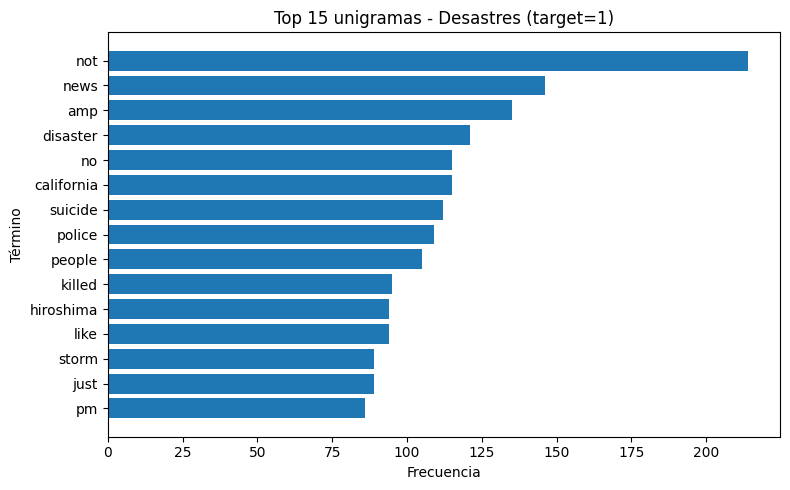

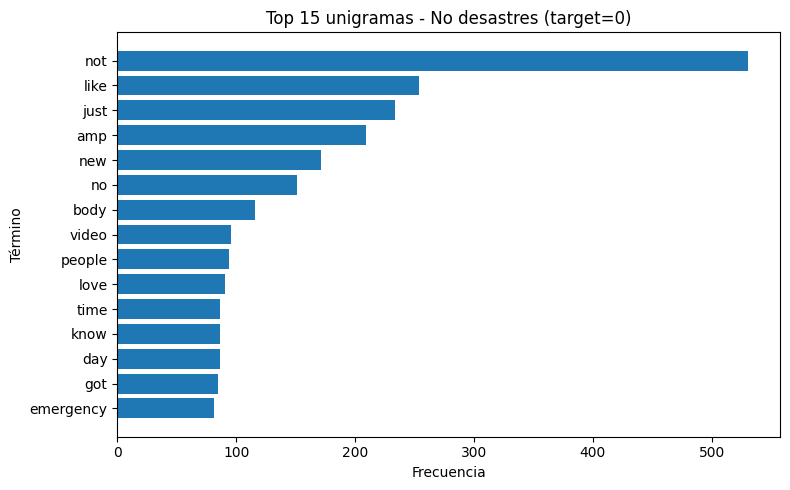

In [17]:
plot_top_bars(top_uni_1, "Top 15 unigramas - Desastres (target=1)", top_n=15)
plot_top_bars(top_uni_0, "Top 15 unigramas - No desastres (target=0)", top_n=15)

#### Bigramas y trigramas por clase (frecuencia)

In [18]:
top_bi_1 = get_top_ngrams(texts_1, ngram_range=(2,2), top_n=25, min_df=1)
top_bi_0 = get_top_ngrams(texts_0, ngram_range=(2,2), top_n=25, min_df=1)
top_tri_1 = get_top_ngrams(texts_1, ngram_range=(3,3), top_n=25, min_df=1)
top_tri_0 = get_top_ngrams(texts_0, ngram_range=(3,3), top_n=25, min_df=1)

In [19]:
display("Top bigramas - Desastres (target=1)", top_bi_1)

'Top bigramas - Desastres (target=1)'

,ngram,freq
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,37
4,suicide bombing,35
5,california wildfire,34
6,bomber detonated,30
7,confirmed mh,29
8,homes razed,29
9,yr old,29


In [20]:
display("Top bigramas - No desastres (target=0)", top_bi_0)

'Top bigramas - No desastres (target=0)'

,ngram,freq
0,cross body,39
1,liked video,34
2,gt gt,30
3,body bag,27
4,body bagging,24
5,burning buildings,23
6,body bags,22
7,reddit quarantine,21
8,did not,21
9,quarantine offensive,21


In [21]:
display("Top trigramas - Desastres (target=1)", top_tri_1)

'Top trigramas - Desastres (target=1)'

,ngram,freq
0,suicide bomber detonated,30
1,northern california wildfire,29
2,homes razed northern,28
3,latest homes razed,28
4,pkk suicide bomber,28
5,bomber detonated bomb,28
6,yr old pkk,27
7,old pkk suicide,27
8,razed northern california,27
9,affected fatal outbreak,26


In [22]:
display("Top trigramas - No desastres (target=0)", top_tri_0)

'Top trigramas - No desastres (target=0)'

,ngram,freq
0,reddit quarantine offensive,21
1,quarantine offensive content,20
2,cross body bag,19
3,pick fan army,17
4,stock market crash,16
5,new content policy,16
6,reddit new content,16
7,china stock market,16
8,hollywood movie trapped,15
9,goes effect horrible,15


### Palabras más informativas (chi-cuadrado)

#### Identificamos términos con mayor asociación estadística a cada clase.

<small>

- `log_ratio > 0` → aparece relativamente más en `target=1` (desastre).
- `log_ratio < 0` → aparece relativamente más en `target=0` (no desastre).

</small>


In [23]:
y = df["target"].astype(int).values
top_disaster, top_nondisaster = chi2_informative_terms(df["clean_text"].fillna(""), y, ngram_range=(1,1), top_k=25, min_df=1)

In [24]:
display("Términos más informativos para Desastres (chi², unigramas)", top_disaster)

'Términos más informativos para Desastres (chi², unigramas)'

,term,chi2,log_ratio
0,california,133.903197,3.236411
1,suicide,127.059709,3.055827
2,hiroshima,121.493276,4.826530
3,killed,113.454993,3.450821
4,mh,93.629588,4.573694
5,families,86.501530,2.731778
6,wildfire,85.167230,3.824197
7,northern,84.955060,16.789298
8,legionnaires,80.972791,16.741289
9,bombing,80.799762,3.404133


In [25]:
display("Términos más informativos para No-Desastres (chi², unigramas)", top_nondisaster)

'Términos más informativos para No-Desastres (chi², unigramas)'

,term,chi2,log_ratio
0,not,61.657727,-0.625547
1,body,53.096230,-1.762300
2,love,43.108062,-1.829725
3,like,36.148154,-0.710800
4,just,31.307654,-0.683445
5,new,31.009681,-0.833073
6,bags,29.733003,-3.477958
7,let,27.594041,-1.408437
8,bag,27.479770,-3.405637
9,lol,26.582510,-1.646670
